# Workspace \#5: ``astro.py``

In [27]:
# getting future division
from __future__ import division

# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
# %matplotlib inline
%matplotlib notebook

%config InlineBackend.figure_format = "retina"
#rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()


SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from random import random

import sys
sys.path.insert(0, '../')

import tools as tl
import constants as ct
import particle as pt
import ska as sk
import astro as ap

In [3]:
# The contents of astro.py
dir(ap)

['AdiabaticErrorMssg',
 'ED_fn',
 'FreeErrorMssg',
 'Galactic',
 'HEALPix',
 'L_adiab',
 'L_arr_default',
 'L_eff',
 'L_free',
 'L_source',
 'L_thy',
 'P_noise',
 'P_signal',
 'R_pheno',
 'Rb_TM99',
 'ST_fn',
 'S_cygA',
 'SkyCoord',
 'Snu_supp',
 'T_atm',
 'T_noise',
 'T_signal',
 'T_sys',
 'Tatm_low_fn',
 'Tatm_mid_fn',
 'Tsky_low',
 'Tsky_mid',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'alpha_from_gamma',
 'bg_408_temp',
 'ct',
 'dimless_adiab',
 'dimless_free',
 'dimless_lum',
 'division',
 'erf',
 'exp',
 'flux',
 'flux_density_to_psd',
 'ftt',
 'gamma_from_alpha',
 'getargspec',
 'hp',
 'irrad',
 'lambertw',
 'local_path',
 'log',
 'log10',
 'lumin',
 'map_allsky_408',
 'np',
 'nu_factor',
 'os',
 'pars_always',
 'pars_early',
 'pars_late',
 'pars_lightcurve',
 'pars_required',
 'path',
 'pheno_age',
 'physics_age',
 'pi',
 'power',
 'psd_to_flux_density',
 'pt',
 'r_to_gal',
 'rho_MW',
 'rho_NFW',
 'sandwich

In [4]:
# parameters required for each astro model. The keys are of the form (model, missing_parameter), for a fixed lightcurve model ('eff'/'thy') and a given missing parameter. The values are then the parameters that need to be known and passed in order to compute the lightcurve. Essentially, the missing parameter is computed based on all the others.

ap.pars_required

{('eff', 'L_today'): ['L_peak', 't_peak', 'gamma', 't_trans', 't_age'],
 ('eff', 'L_peak'): ['t_peak', 'gamma', 't_trans', 't_age', 'L_today'],
 ('eff', 't_age'): ['L_peak', 't_peak', 'gamma', 't_trans', 'L_today'],
 ('eff', 't_trans'): ['L_peak', 't_peak', 'gamma', 'L_today', 't_age'],
 ('thy', 'L_today'): ['L_norm',
  'K2',
  'beta',
  'delta',
  't_trans',
  'gamma',
  't_age'],
 ('thy', 'L_norm'): ['K2',
  'beta',
  'delta',
  't_trans',
  'gamma',
  't_age',
  'L_today']}

## **NOTA BENE:**

### When using either of the spectral luminosities (at peak day, $L_{\rm peak, \, \nu}$; and today, $L_{\rm today, \, \nu}$) to compute the lightcurve, make sure they are evaluated **at the same frequency $\nu$, which _must_ be the pivot frequency $\nu_{\rm pivot}$**. Otherwise, the lighcturve is inconsistent.

Testing that different approaches to the lightcurve models give the same results:

## 1. Lightcurve

### 1.1 Exact (numeric)

In [5]:
# compute lightcurve for different models and approaches
t_peak = 100. # [days] # DO NOT CHANGE IN ORDER TO COMPARE
t_age = 300. # [years]
t_trans = 1. # [years] # DO NOT CHANGE IN ORDER TO COMPARE
t_arr = np.array([t_peak/365., t_trans, t_age]) # [years]

# doing 'eff'

L_peak = 1.e28

source_input = []
approach = []

approach.append('missing L_today')
source_input.append(('eff', {'L_peak':L_peak, 't_peak':t_peak, 'gamma':1., 't_trans':t_trans, 't_age':t_age}))

L_today = ap.L_source(t=t_age,
                      model=source_input[0][0],
                      output_pars=False,
                      **source_input[0][1])

approach.append('missing L_peak')
source_input.append(('eff', {'L_today':L_today, 't_age':t_age, 't_peak':t_peak, 'gamma':1., 't_trans':t_trans, 't_age':t_age}))

approach.append('missing t_trans')
source_input.append(('eff', {'L_today':L_today, 'L_peak':L_peak, 't_age':t_age, 't_peak':t_peak, 'gamma':1.}))

approach.append('missing t_age')
source_input.append(('eff', {'L_today':L_today, 'L_peak':L_peak, 't_trans':t_trans, 't_peak':t_peak, 'gamma':1.}))

print("------------------\nMODEL: 'eff'\n------------------\n")

L_fns = {}
for i, val in enumerate(source_input):
    
    model = val[0]
    pars = val[1]
    
    print(approach[i]+':')
    print(val)
    print('\n(time, Lum): %s' %([(t, ap.L_source(t=t,
                                           model=model,
                                           output_pars=False,
                                           **pars)) for t in t_arr]))
    print('pars: %s\n..................\n' %(ap.L_source(t=t_age,
                                model=model,
                                output_pars=True, **pars)[-1]))


# doing 'thy'
t_check = t_peak # [days]
t_arr = np.array([t_check/365., t_trans, t_age]) # [years]

K2 = 2.4e3 # DO NOT CHANGE IN ORDER TO COMPARE

print("\n------------------\nMODEL: 'thy'\n------------------\n")

approach.append('missing L_norm')
source_input.append(('thy', {'L_today':L_today, 't_age':t_age, 'beta':0.64, 'K2':K2, 'delta':2.82, 'gamma':1., 't_trans':t_trans, 'tau_factor':((1./5.)**-2.1)}))

L_norm = 1.8672956e+29 * (L_today/1.4203781639864318e+25) # DO NOT CHANGE IN ORDER TO COMPARE

approach.append('missing L_today')
source_input.append(('thy', {'L_norm':L_norm, 'beta':0.64, 'K2':K2, 'delta':2.82, 'gamma':1., 't_trans':t_trans, 't_age':t_age, 'tau_factor':((1./5.)**-2.1)}))

for i, val in enumerate(source_input):
    
    model = val[0]
    pars = val[1]
    
    if model != 'thy':
        continue
    
    print(approach[i]+':')
    print(val)
    print('\n(time, Lum):%s' %([(t, ap.L_source(t=t,
                                           model=model,
                                           output_pars=False,
                                           **pars)) for t in t_arr]))
    print('pars: %s\n..................\n' %(ap.L_source(t=t_age,
                                model=model,
                                output_pars=True,
                                **pars)[-1]))

------------------
MODEL: 'eff'
------------------

missing L_today:
('eff', {'L_peak': 1e+28, 't_peak': 100.0, 'gamma': 1.0, 't_trans': 1.0, 't_age': 300.0})

(time, Lum): [(0.273972602739726, 1e+28), (1.0, 4.261134491959295e+27), (300.0, 1.4203781639864318e+25)]
pars: {'L_peak': 1e+28, 't_peak': 100.0, 'gamma': 1.0, 't_trans': 1.0, 't_age': 300.0, 'L_today': 1.4203781639864318e+25, 'L_ref': 4.261134491959295e+27, 't_ref': 1.0}
..................

missing L_peak:
('eff', {'L_today': 1.4203781639864318e+25, 't_age': 300.0, 't_peak': 100.0, 'gamma': 1.0, 't_trans': 1.0})

(time, Lum): [(0.273972602739726, 1e+28), (1.0, 4.261134491959295e+27), (300.0, 1.4203781639864318e+25)]
pars: {'t_peak': 100.0, 'gamma': 1.0, 't_trans': 1.0, 't_age': 300.0, 'L_today': 1.4203781639864318e+25, 'L_peak': array(1.e+28), 'L_ref': 1.4203781639864318e+25, 't_ref': 300.0}
..................

missing t_trans:
('eff', {'L_today': 1.4203781639864318e+25, 'L_peak': 1e+28, 't_age': 300.0, 't_peak': 100.0, 'gamma'

Comparing the lightcuarves from different approaches:

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


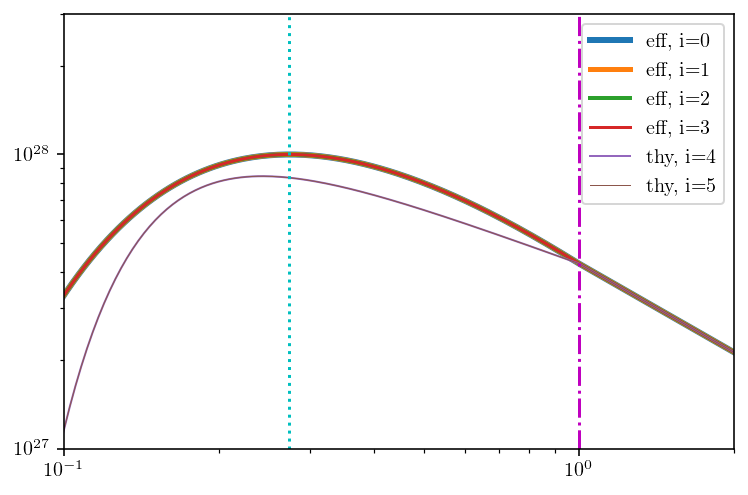

In [6]:
t_arr = np.logspace(log10(1./365), log10(t_age)+0.5, 1001)

max_w = len(source_input)*.5
for i, mod_pars in enumerate(source_input):
    
    model, params = mod_pars
    
    Lfn = lambda tt: ap.L_source(t=tt, model=model, output_pars=False, **params)
    
    plt.loglog(t_arr, Lfn(t_arr), label="{}, i={}".format(model, i), lw=max_w-0.5*i)

plt.axvline(t_age, ls='-', color='k')
plt.axvline(t_trans, ls='-.', color='m')
plt.axvline(t_peak/365, ls=':', color='c')

plt.xlim(0.1, 2.);plt.ylim(1.e27, 3.e28);
# plt.ylim(1.e20, 1.e30);
plt.legend();

Yet another example of lightcurve comparison: Cassiopeia A

{'L_peak': 1e+30, 't_peak': 100.0, 'gamma': 2.03, 't_trans': 32.59251578472727, 't_age': 300.0, 'L_today': 3.7663679059949214e+25, 'L_ref': 3.410747597976396e+27, 't_ref': 32.59251578472727}
(1001,) (1001,)


True

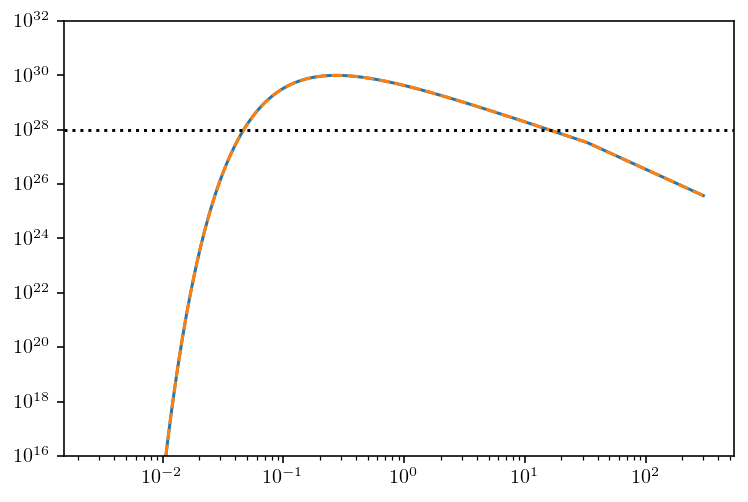

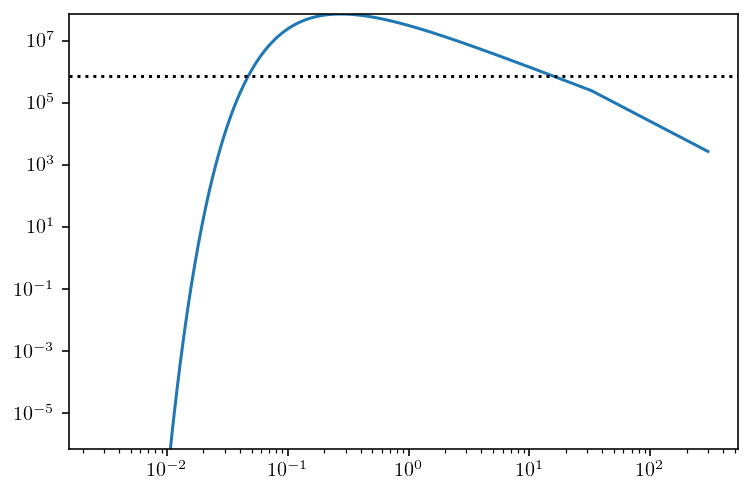

In [7]:
# Cassiopeia A lightcurve

output={}

D = 3.4 # [kpc] Cas A
A = 4.*pi*(D*ct._kpc_over_cm_)**2. # [cm^2] area
SnuCasA = 2723 # [Jy] Cas A

LumCasA = (SnuCasA*ct._Jy_over_cgs_irrad_)*A

source_input = {'longitude':111.734745, # Cas A
                'latitude':-02.129570, # Cas A
                'distance':D, # Cas A
                'size':1.e-6,
                't_age':300., # Cas A
                'alpha':0.77,
                'nu_pivot':1.,
                'gamma':2.03, # Cas A experiment
                'model':'eff', 'L_today':LumCasA, 'L_peak':1.e30,
                't_peak':100.
               }

import echo as ec # temporarily, just to check with the spectral irradiance function in that module
ec.check_source(source_input)

t_arr = np.logspace(log10(1./365), log10(source_input['t_age']), 1001)
t_ref = 1.
nu_arr = np.logspace(-4, 1, 1001)

_, pars = ap.L_source(t_ref,
                      output_pars=True,
                      **source_input)
print(pars)

t, nu = t_arr, 1.
fac = ap.nu_factor(nu, source_input['nu_pivot'], source_input['alpha'])

Lnu = ap.L_source(t, output_pars=False, **source_input)**fac

Snu = ec.Snu_source(t, nu, source_input, output=output)

print('%s %s' %(Snu.shape, Lnu.shape))

fig_num = int(random()*100)
Area = 4.*pi*(source_input['distance']*ct._kpc_over_cm_)**2.

plt.figure(fig_num)
plt.loglog(t_arr, (Snu*ct._Jy_over_cgs_irrad_)*Area)
plt.loglog(t_arr, Lnu, ls='--')
plt.ylim(1.e16, 1.e32);
plt.axhline(1.e28, c='k', ls=':')

fig_num += 1
plt.figure(fig_num)
plt.loglog(t_arr, Snu)
plt.ylim(1.e16 /(Area*ct._Jy_over_cgs_irrad_), 1.e30 /(Area*ct._Jy_over_cgs_irrad_));
plt.axhline(1.e28 /(Area*ct._Jy_over_cgs_irrad_), c='k', ls=':')

# updating data
ec.Snu_source(t_arr, nu_arr, source_input, output=output)
'source_t-nu-Snu' in output.keys()

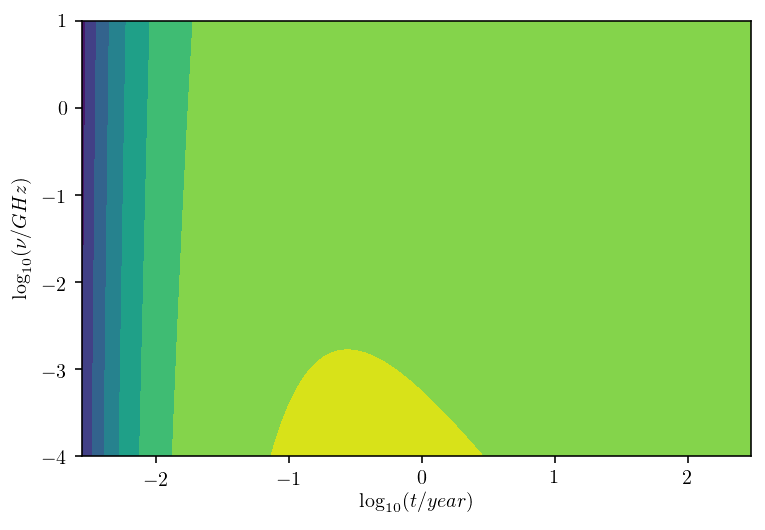

In [8]:
tArr, nuArr, SnuGr = output['source_t-nu-Snu']

plt.contourf(log10(tArr), log10(nuArr), log10(SnuGr))
plt.xlabel(r'$\log_{10}(t/year)$');plt.ylabel(r'$\log_{10}(\nu/GHz)$');

In [9]:
# more tests

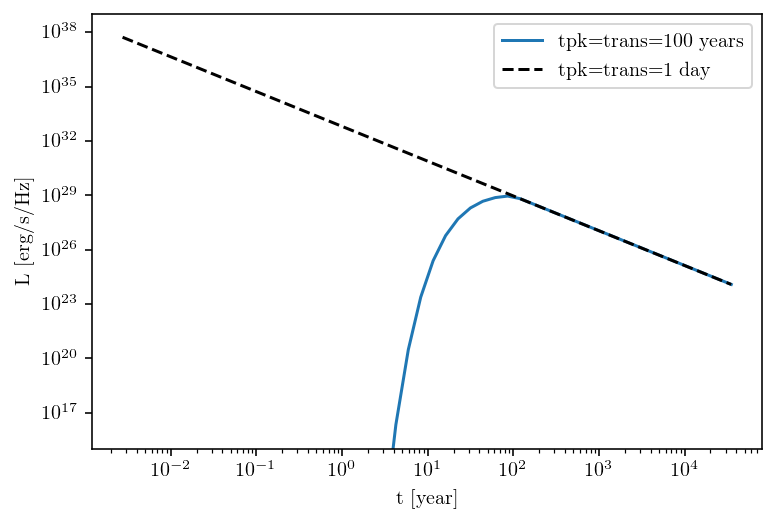

In [10]:
plt.subplots()
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e15, 1e39)
plt.xlabel('t [year]')
plt.ylabel('L [erg/s/Hz]')


longitude = 6.4 #175 #175 #178 #10 #179 # 111.734745
latitude = -0.1 # -02.129570
D = 1.8 #0.5 #[kpc]
alpha = 0.7
gamma = ap.gamma_from_alpha(alpha)
t_peak = 100.*365  #100 * 365
t_trans = t_peak /365
t_age = 35000
S0 = 310 #Jy
L_today = S0 * ct._Jy_over_cgs_irrad_ * 4.*np.pi * (D*ct._kpc_over_cm_)**2
ang_size = 1.5e-4 #None #1.5e-4#None #snr_ang_size(D) #1.7e-4 #1e-6 #1e-5 #1e-4 #

source_input = {'longitude':longitude,
                'latitude':latitude, 
                'distance':D, 
                'size':ang_size,
                't_age':t_age, 
                'alpha':alpha,
                'nu_pivot':1.,
                'gamma':gamma, # Cas A experiment
                'model': "eff", 'L_today': L_today, 't_peak': t_peak, 't_trans': t_trans,
                'force_Omega_disp_compute': True
               }

t_arr = np.logspace(np.log10(1./365), np.log10(source_input['t_age']))
L_arr = ap.L_source(t_arr, **source_input)
plt.plot(t_arr, L_arr, label='tpk=trans=100 years')

t_peak = 1. 
t_trans = t_peak /365
t_age = 35000-100
source_input['t_peak'] = t_peak
source_input['t_trans'] = t_trans
source_input['t_age'] = t_age
t_arr = np.logspace(np.log10(t_peak/365), np.log10(source_input['t_age']))
L_arr = ap.L_source(t_arr, **source_input)
plt.plot(t_arr, L_arr, 'k--', label='tpk=trans=1 day')


# t_peak = 1. 
# t_trans = t_peak /365
# t_age = 35000*(1./(100.*365))
# source_input['t_peak'] = t_peak
# source_input['t_trans'] = t_trans
# source_input['t_age'] = t_age
# t_arr = np.logspace(np.log10(t_peak/365), np.log10(source_input['t_age']))
# L_arr = ap.L_source(t_arr, **source_input)
# plt.plot(t_arr, L_arr, 'r:', label='tpk=trans=1 day, shifted')

plt.legend(loc='best')

### 1.2 Analytic

``astro.py`` also containts analytic formulas for the lightcurve.

In [11]:
help(ap.Snu_supp)

Help on function Snu_supp in module astro:

Snu_supp(gamma, frac_tpk, frac_tt)
    Fractional suppression of spectral irradiance (i.e. S0/S_peak = L0/L_peak).
    
    Parameters
    ----------
    gamma : adiabatic index
    frac_tpk : ratio of peak day to SNR age
    frac_tt : ratio of transition time to SNR age



In [12]:
help(ap.ftt)

Help on function ftt in module astro:

ftt(gamma, frac_tpk, sup)
    Fractional transition time (i.e. t_trans/t_age).
    
    Parameters
    ----------
    gamma : adiabatic index
    frac_tpk : ratio of peak day to SNR age
    sup : spectral irradiance suppression



In [13]:
help(ap.dimless_free)

Help on function dimless_free in module astro:

dimless_free(frac_tpk, tau)
    Dimensionless free expansion lightcurve.
    
    Parameters
    ----------
    frac_tpk : ratio of peak day to SNR age
    tau : ratio of time to SNR age



In [14]:
help(ap.dimless_adiab)

Help on function dimless_adiab in module astro:

dimless_adiab(gamma, sup, tau)
    Dimensionless adiabatic expansion lightcurve.
    
    Parameters
    ----------
    gamma : adiabatic index
    sup : spectral irradiance suppression
    tau : ratio of time to SNR age



In [15]:
help(ap.dimless_lum)

Help on function dimless_lum in module astro:

dimless_lum(gamma, frac_tpk, sup, tau)
    Dimensionless full lightcurve.
    
    Parameters
    ----------
    gamma : adiabatic index
    frac_tpk : ratio of peak day to SNR age
    sup : spectral irradiance suppression
    tau : ratio of time to SNR age



## 2. Observation

In [16]:
# background brightness temperature at 408 MHz
ap.bg_408_temp(0., 0.)

725.22614

In [17]:
print(ap.T_sys(1., Tr=0.))
print(ap.T_sys(1., Tr=10.*np.ones(5)))

8.019953246739677
[18.01995325 18.01995325 18.01995325 18.01995325 18.01995325]


In [18]:
help(ap.P_noise)

Help on function P_noise in module astro:

P_noise(T_sys, delnu, tobs, Omega_obs, Omega_res, nu, correlation_mode)
    The power of the noise [eV^2].
    
    Parameters
    ----------
    T_sys: the temperature of the noise [K]
    delnu: the bandwidth of the detector [GHz]
    tobs: the total observation time [hour]
    Omega_obs: the observation solid angle [sr]
    Omega_res: the resolution solid angle [sr]
    correlation_mode: the correlation mode, "single dish" or "interferometry".



In [19]:
help(ap.P_signal)

Help on function P_signal in module astro:

P_signal(S, A, eta=None, f_Delta=1.0)
    The signal power, assuming given bandwidth [eV^2].
    
    Parameters
    ----------
    S: the (integrated) flux (irradiance) [eV^4]
    A: the area of the detector [m^2]
    eta: the detector efficiency (default: 0.8)
    f_Delta: the fraction of signal falling withing the bandwidth



## 3. Background

In [22]:
ap.bg_408_temp(10, 10, size=1e-2, average=True)

array(74.21291, dtype=float32)

In [23]:
ap.bg_408_temp(10, 10, size=[1e-2], average=True)

array([74.21291], dtype=float32)

In [24]:
ap.bg_408_temp(10, 10, size=[1e-2, 1e-3, 1e-4], average=True)

array([74.21291, 68.28747, 67.52624], dtype=float32)

In [25]:
ap.bg_408_temp(10, 10, size=[1e-2, 1e-3, 1e-4], average=False)

array([67.48344, 67.48344, 67.48344], dtype=float32)

## 4. Optimizing background loading

In [26]:
%timeit ap.bg_408_temp(l=10,b=10,size=[1e-4,1e-2,1e-3,1e-2], average=True, load_on_the_fly=True, verbose=False)

96.4 ms ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
%timeit ap.bg_408_temp(l=10,b=10,size=[1e-4,1e-2,1e-3,1e-2], average=True)

1.54 ms ± 942 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## 5. Check Haslem map angular resolution

In [28]:
import astropy_healpix
astropy_healpix.nside_to_pixel_resolution(nside=512)

<Quantity 6.87097282 arcmin>

In [29]:
6.9/60/180*np.pi

0.002007128639793479

## 6. Noise for different SKA modes

In [30]:
ap.P_noise(T_sys=100, 
           delnu=0.05e-3, 
           tobs=100, 
           Omega_obs=1.5e-4, 
           Omega_res=1e-3, 
           nu=0.05, 
           correlation_mode="single dish")

3.025083593413625e-18

In [31]:
ap.P_noise(T_sys=100, 
           delnu=0.05e-3, 
           tobs=100, 
           Omega_obs=1.5e-4, 
           Omega_res=None,
           nu=0.05, 
           correlation_mode="interferometry")

array(1.78848124e-19)

In [32]:
ap.T_noise(T_sys=100,
           delnu=0.05e-3, 
           tobs=100, 
           Omega_obs=1.5e-4, 
           Omega_res=None,
           nu=0.05, 
           correlation_mode="interferometry")

6.158512560360823e-08

## 7. Misc

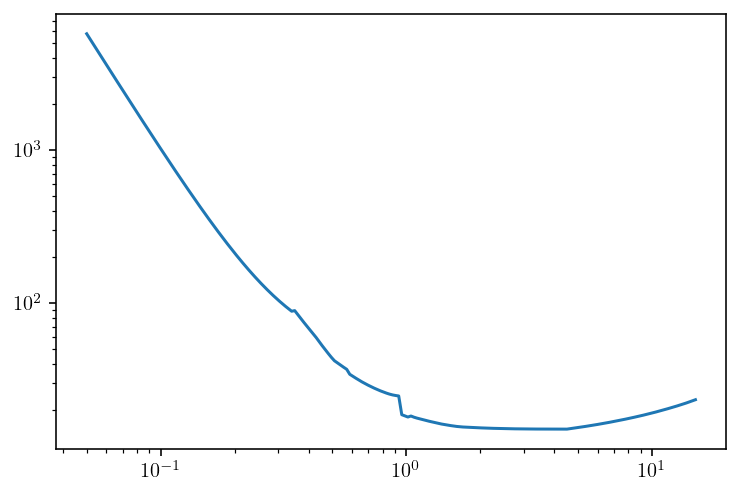

In [5]:
tmp_nu_arr = np.logspace(np.log10(0.05), np.log10(15), 200)
T_sys_arr = ap.T_sys(tmp_nu_arr)
plt.subplots()
plt.plot(tmp_nu_arr, T_sys_arr)
plt.xscale('log')
plt.yscale('log')


<IPython.core.display.Javascript object>


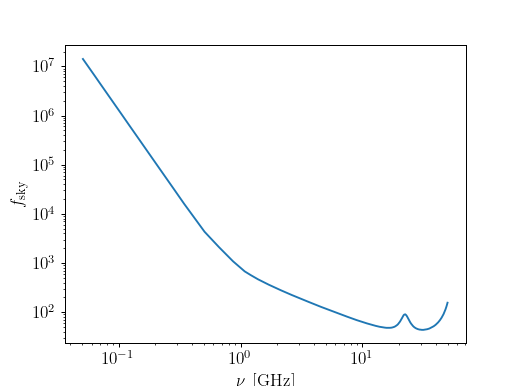

In [31]:
# estimate inverse process
plt.subplots()
nu_arr = np.concatenate((sk.Tsky_low[:,0], sk.Tsky_mid[:,0]))
Tsky_arr = np.concatenate((sk.Tsky_low[:,1], sk.Tsky_mid[:,1]))
plt.plot(nu_arr, Tsky_arr*ct._K_over_eV_/(nu_arr*ct._GHz_over_eV_))#, label=r'$f_{\rm sky}$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$f_{\rm sky}$')
plt.xlabel(r'$\nu$ [GHz]')
#plt.legend()
plt.savefig('../plots/fsky.pdf')

<IPython.core.display.Javascript object>


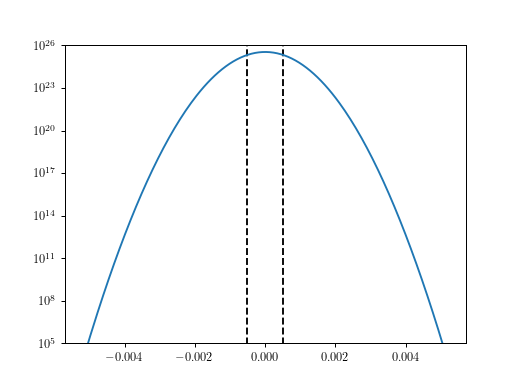

(100000.0, 1e+26)

In [26]:
ma = 1e-5
v_arr = np.linspace(-10 * ct._sigma_v_, 10 * ct._sigma_v_, 200)
plt.subplots()
plt.plot(v_arr, pt.fa(1e-5, v_arr))
plt.vlines([-ct._sigma_v_, ct._sigma_v_], 1, 1e26, linestyles='--', color='k')

#plt.xscale('log')
plt.yscale('log')
plt.ylim(1e5, 1e26)